# Sentiment Analysis

Research Question: What linguistic patterns and sentiment markers are most indicative of suicidal intent in social media text?

Note: This notebook exports analysis results to `.jsonl` files under `N-Gram Analysis` directory.

## Import Relevant Modules

In [1]:
import os
import sys
DATA_PATH = os.path.abspath(os.path.join(os.path.dirname(os.curdir), 'data'))
ASSIGNMENT_1_PATH = os.path.abspath(
    os.path.join(
        os.path.dirname(os.curdir), 
        "..",
        'Assignment 1',
        "src"
        )
)
sys.path.append(DATA_PATH)
sys.path.append(ASSIGNMENT_1_PATH)
import shutil
import re
from collections import Counter
import numpy as np
import pandas as pd
import json
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
print(f"Installation of nltk.sentiment.vader success?: {'Yes' if nltk.download('vader_lexicon') else 'No'}")
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kelvi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Installation of nltk.sentiment.vader success?: Yes


In [2]:
stopwords = open(
    os.path.join(
        ASSIGNMENT_1_PATH, 
        "StopWords.txt"
    ), "r").read().splitlines()
print(f"Number of Stopwords in consideration: {len(stopwords)}")

Number of Stopwords in consideration: 779


## Fetch the Texts from the Datasets

In [3]:
depression = pd.read_json(
    os.path.join(
        DATA_PATH, 
        'Depression_Tweets', 
        'depression_json'
    )
)
reddit = pd.read_csv(
    os.path.join(
        DATA_PATH, 
        'Reddit_SuicideWatch', 
        'reddit_suicidewatch.csv'
    ), 
    encoding='utf-8'
)
social_media_sentiment_analysis = pd.read_csv(
    os.path.join(
        DATA_PATH, 
        'Social_Media_Sentiments_Analysis_Dataset', 
        'sentimentdataset_annotated_binary.csv'
    ), 
    encoding='utf-8'
)
twitter_suicidal_data = pd.read_csv(
    os.path.join(
        DATA_PATH, 
        'Twitter_Suicidal_Data', 
        'twitter-suicidal_data.csv'
    ), 
    encoding='utf-8'
)


In [4]:
depression.columns

Index(['content'], dtype='object')

In [5]:
reddit.columns

Index(['subreddit', 'selftext', 'author_fullname', 'title', 'hide_score',
       'name', 'upvote_ratio', 'ups', 'author_flair_template_id', 'score',
       'edited', 'author_flair_css_class', 'created', 'selftext_html',
       'no_follow', 'over_18', 'id', 'author', 'num_comments',
       'author_flair_text_color', 'permalink', 'url', 'created_utc'],
      dtype='object')

In [6]:
social_media_sentiment_analysis.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour', 'Annotation'],
      dtype='object')

In [7]:
twitter_suicidal_data.columns

Index(['tweet', 'intention'], dtype='object')

## N-Gram Analysis

Performs an n-gram analysis (from 2-gram to 5-gram) and exports results to corresponding `.jsonl` files.

In [8]:
def get_n_gram(n: int=2, corpus: str="", stopwords: list=[]):
    pattern = re.compile(r'\b\w+\b')
    # filtered corpus should have no punctuations AND stopwords
    filtered_corpus = [word for word in corpus if pattern.match(word) and word not in stopwords]
    # Compute bigrams from the filtered corpus
    ngrams = [tuple(filtered_corpus[i:i+n]) for i in range(len(filtered_corpus)-n+1)]
    return ngrams

In [9]:
# Ensure the output directory exists
output_dir = 'N-Gram Analysis'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

datasets = {
    "depression_ngram.json": [],
    "reddit_ngram.json": [],
    "social_media_sentiment_analysis_ngram.json": [],
    "twitter_suicidal_ngram.json": []
}

# Print and Export top 20 n-grams for each dataset
for N in range(2, 6):  # bigram to 5-gram combinations
    # Depression
    print(f"{N}-gram from Depression JSON dataset:\n")

    ngrams_depression = get_n_gram(
        n=N,
        corpus=depression['content'][0].split(),
        stopwords=stopwords
    )

    print(f"Number of {N}-gram from Depression JSON dataset: {len(ngrams_depression)}")

    ngrams_depression_top_20 = Counter(ngrams_depression).most_common(20)
    print(f"First 20 {N}-grams from Depression JSON dataset: {ngrams_depression_top_20}")
        
    # Transform to desired format
    formatted_ngrams = [
        {"content": " ".join(ngram), "N-gram": N, "frequency": freq}
        for ngram, freq in ngrams_depression_top_20
    ]
    datasets["depression_ngram.json"].extend(formatted_ngrams)

    # Reddit
    print(f"{N}-gram from Reddit SuicideWatch dataset:\n")

    reddit['combined_text'] = reddit['title'] + " " + reddit['selftext']
    ngrams_reddit = get_n_gram(
        n=N,
        corpus=reddit['combined_text'][0].split(),
        stopwords=stopwords
    )

    print(f"Number of {N}-gram from Reddit SuicideWatch dataset: {len(ngrams_reddit)}")

    ngrams_reddit_top_20 = Counter(ngrams_reddit).most_common(20)
    print(f"First 20 {N}-grams from Reddit SuicideWatch dataset: {ngrams_reddit_top_20}")
        
    # Transform to desired format
    formatted_ngrams = [
        {"content": " ".join(ngram), "N-gram": N, "frequency": freq}
        for ngram, freq in ngrams_reddit_top_20
    ]
    datasets["reddit_ngram.json"].extend(formatted_ngrams)

    # Social Media Sentiment Analysis
    print(f"{N}-gram from Social Media Sentiment Analysis dataset:\n")

    social_media_sentiment_analysis['combined_text'] = social_media_sentiment_analysis['Text'] + " " + social_media_sentiment_analysis['Hashtags']
    ngrams_social_media_sentiment_analysis = get_n_gram(
        n=N,
        corpus=social_media_sentiment_analysis['combined_text'][0].split(),
        stopwords=stopwords
    )

    print(f"Number of {N}-gram from Social Media Sentiment Analysis dataset: {len(ngrams_social_media_sentiment_analysis)}")

    ngrams_social_media_sentiment_analysis_top_20 = Counter(ngrams_social_media_sentiment_analysis).most_common(20)
    print(f"First 20 {N}-grams from Social Media Sentiment Analysis dataset: {ngrams_social_media_sentiment_analysis_top_20}")
        
    # Transform to desired format
    formatted_ngrams = [
        {"content": " ".join(ngram), "N-gram": N, "frequency": freq}
        for ngram, freq in ngrams_social_media_sentiment_analysis_top_20
    ]
    datasets["social_media_sentiment_analysis_ngram.json"].extend(formatted_ngrams)

    # Twitter Suicidal Data
    print(f"{N}-gram from Twitter Suicidal dataset:\n")

    ngrams_twitter_suicidal_data = get_n_gram(
        n=N,
        corpus=twitter_suicidal_data['tweet'][0].split(),
        stopwords=stopwords
    )

    print(f"Number of {N}-gram from Twitter Suicidal dataset: {len(ngrams_twitter_suicidal_data)}")

    ngrams_twitter_suicidal_data_top_20 = Counter(ngrams_twitter_suicidal_data).most_common(20)
    print(f"First 20 {N}-grams from Twitter Suicidal dataset: {ngrams_twitter_suicidal_data_top_20}")
        
    # Transform to desired format
    formatted_ngrams = [
        {"content": " ".join(ngram), "N-gram": N, "frequency": freq}
        for ngram, freq in ngrams_twitter_suicidal_data_top_20
    ]
    datasets["twitter_suicidal_ngram.json"].extend(formatted_ngrams)

# Export to JSON files
for filename, data in datasets.items():
    with open(os.path.join(output_dir, filename), 'a') as f:
        json.dump(data, f, indent=4)

2-gram from Depression JSON dataset:

Number of 2-gram from Depression JSON dataset: 7
First 20 2-grams from Depression JSON dataset: [(('Yea', 'typically'), 1), (('typically', 'crying'), 1), (('crying', 'sign'), 1), (('sign', 'uncontrolled'), 1), (('uncontrolled', 'depression'), 1), (('depression', 'struggled'), 1), (('struggled', "life'"), 1)]
2-gram from Reddit SuicideWatch dataset:

Number of 2-gram from Reddit SuicideWatch dataset: 106
First 20 2-grams from Reddit SuicideWatch dataset: [(('I', 'left'), 2), (('Help?', 'I'), 1), (('I', 'reached'), 1), (('reached', 'point'), 1), (('point', 'today.'), 1), (('today.', 'I'), 1), (('I', 'struggling'), 1), (('struggling', 'lot'), 1), (('lot', 'financially'), 1), (('financially', 'trying'), 1), (('trying', 'support'), 1), (('support', 'kids.'), 1), (('kids.', 'I'), 1), (('I', 'lose'), 1), (('lose', 'house.'), 1), (('house.', 'I'), 1), (('I', 'work'), 1), (('work', 'full'), 1), (('full', 'I'), 1), (('I', "it's"), 1)]
2-gram from Social Medi

### N-gram Analysis based on Prediction Results

In [10]:
RESULTS_PATH = os.path.abspath(
    os.path.join(
        "NLP Training", 
        'Results'
        )
)

In [11]:
results = {}
for jsonFile in os.listdir(RESULTS_PATH):
    if jsonFile.endswith('.json') or jsonFile.endswith('.jsonl'):
        with open(os.path.join(RESULTS_PATH, jsonFile), 'r') as f:
            data = [json.loads(line) for line in f]
            print(f"Number of records in {jsonFile}: {len(data)}")
            for N in range(2, 6):
                ngram_results: list[tuple] = get_n_gram(
                    n=N,
                    corpus=data[0]['raw_text'].split(),
                    stopwords=stopwords
                )
                print(f"Number of {N}-gram from {jsonFile}: {len(ngram_results)}")
                ngram_results_top_20 = Counter(ngram_results).most_common(20)
                print(f"First 20 {N}-grams from {jsonFile}: {ngram_results_top_20}")
                print("\n")
                # For exporting
                if jsonFile not in results:
                    results[jsonFile] = []
                results[jsonFile].extend([
                    {"content": " ".join(ngram), "N-gram": N, "frequency": freq, "predicted_label": data[0]['predicted_label']}
                    for ngram, freq in ngram_results_top_20
                ])
    
    # Export to JSON files
    if jsonFile.startswith('Result_') and (jsonFile.endswith('.json') or jsonFile.endswith('.jsonl')):
        with open(os.path.join(output_dir, f'pred_results_{jsonFile.split("Result_")[1].split(".")[0]}.json'), 'a') as f:
            json.dump(results[jsonFile], f, indent=4)

Number of records in BEST_Results.jsonl: 18679
Number of 2-gram from BEST_Results.jsonl: 7
First 20 2-grams from BEST_Results.jsonl: [(('Yea', 'typically'), 1), (('typically', 'crying'), 1), (('crying', 'sign'), 1), (('sign', 'uncontrolled'), 1), (('uncontrolled', 'depression'), 1), (('depression', 'struggled'), 1), (('struggled', "life'"), 1)]


Number of 3-gram from BEST_Results.jsonl: 6
First 20 3-grams from BEST_Results.jsonl: [(('Yea', 'typically', 'crying'), 1), (('typically', 'crying', 'sign'), 1), (('crying', 'sign', 'uncontrolled'), 1), (('sign', 'uncontrolled', 'depression'), 1), (('uncontrolled', 'depression', 'struggled'), 1), (('depression', 'struggled', "life'"), 1)]


Number of 4-gram from BEST_Results.jsonl: 5
First 20 4-grams from BEST_Results.jsonl: [(('Yea', 'typically', 'crying', 'sign'), 1), (('typically', 'crying', 'sign', 'uncontrolled'), 1), (('crying', 'sign', 'uncontrolled', 'depression'), 1), (('sign', 'uncontrolled', 'depression', 'struggled'), 1), (('uncont

## Sentiment Analysis

Analyze the Sentiments (i.e., Polarity and Subjectivity) of the top 20 n-grams in each dataset and updates the files.

In [12]:
sia = SentimentIntensityAnalyzer()
def analyze_sentiment(record):
    text = str(record['content'])
    scores = sia.polarity_scores(text)
    # Map VADER scores to a similar structure
    record['polarity_VADER'] = scores['compound']  # Ranges from -1 to 1
    record['positive'] = scores['pos']
    record['negative'] = scores['neg']
    record['neutral'] = scores['neu']
    return record

In [13]:
ngram_analysis_sets: dict = {}

for ngram_result_file in os.listdir(os.path.join(output_dir)):
    with open(os.path.join(output_dir, ngram_result_file), 'r') as f:
        data = json.load(f)
        ngram_analysis_sets[ngram_result_file] = data
        if isinstance(data, dict):
            for key, value in data.items():
                for record in value:
                    # TextBlob
                    wiki = TextBlob(str(record['content']))
                    record['polarity_TextBlob'] = wiki.sentiment.polarity
                    record['subjectivity'] = wiki.sentiment.subjectivity
                    # VADER
                    wiki = analyze_sentiment(record)
                    ngram_analysis_sets[ngram_result_file][key].append(wiki)
        if isinstance(data, list):
            for idx, record in enumerate(data):
                # TextBlob
                wiki = TextBlob(str(record['content']))
                record['polarity_TextBlob'] = wiki.sentiment.polarity
                record['subjectivity'] = wiki.sentiment.subjectivity
                # VADER
                wiki = analyze_sentiment(record)
                ngram_analysis_sets[ngram_result_file][idx] = wiki
        print(f"✅ {ngram_result_file.split('.json')[0].split('_ngram')[0].upper()} dataset: Polarity and Subjectivity are computed.")

    # Export updates to JSON files
    with open(os.path.join(output_dir, ngram_result_file), 'w') as f:
        json.dump(ngram_analysis_sets[ngram_result_file], f, indent=4)
        print(f"✅ {ngram_result_file.split('.json')[0].split('_ngram')[0].upper()} updated with polarity and subjectivity")


✅ DEPRESSION dataset: Polarity and Subjectivity are computed.
✅ DEPRESSION updated with polarity and subjectivity
✅ PRED_RESULTS_BASELINE_LOGISTIC_REGRESSION dataset: Polarity and Subjectivity are computed.
✅ PRED_RESULTS_BASELINE_LOGISTIC_REGRESSION updated with polarity and subjectivity
✅ PRED_RESULTS_DEEP_LEARNING_CUSTOMIZED_STANDALONE dataset: Polarity and Subjectivity are computed.
✅ PRED_RESULTS_DEEP_LEARNING_CUSTOMIZED_STANDALONE updated with polarity and subjectivity
✅ PRED_RESULTS_DEEP_LEARNING_DISTILBERT_MODEL dataset: Polarity and Subjectivity are computed.
✅ PRED_RESULTS_DEEP_LEARNING_DISTILBERT_MODEL updated with polarity and subjectivity
✅ PRED_RESULTS_HYBRID_MODEL dataset: Polarity and Subjectivity are computed.
✅ PRED_RESULTS_HYBRID_MODEL updated with polarity and subjectivity
✅ PRED_RESULTS_LLM_DEEPSEEK dataset: Polarity and Subjectivity are computed.
✅ PRED_RESULTS_LLM_DEEPSEEK updated with polarity and subjectivity
✅ REDDIT dataset: Polarity and Subjectivity are comp

**Polarity** from TextBlob:
* A float within the range [-1.0, 1.0]. A score of -1 means the words are super negative, like “disgusting” or “awful.” A score of 1 means the words are super positive, like “excellent” or “best”.

**Subjectivity** from TextBlob:
* A float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

Source: <url>https://textblob.readthedocs.io/en/dev/quickstart.html</url>

**Polarity** from VADER:
* A float within the range [-1.0, 1.0]. A score of -1 means the words are super negative. A score of 1 means the words are super positive, like “excellent” or “best”.

**Positivity** from VADER:
* A float within the range [0.0, 1.0] indicating the proportion of Positive sentiments.

**Negativity** from VADER:
* A float within the range [0.0, 1.0] indicating the proportion of Negative sentiments.

**Neutral Score** from VADER:
* A float within the range [0.0, 1.0] indicating the proportion of Neutral sentiments.

Source: <url>https://www.nltk.org/api/nltk.html</url>

## Visualize Analysis

In [14]:
dataframes = {}
for jsonfile in os.listdir(output_dir):
    df = pd.read_json(os.path.join(output_dir, jsonfile))
    df["mean_polarity"] = (df["polarity_TextBlob"] + df["polarity_VADER"]) / 2
    dataframes[jsonfile.split(".json")[0]] = df

In [15]:
import seaborn as sns

### Polarity Distributions

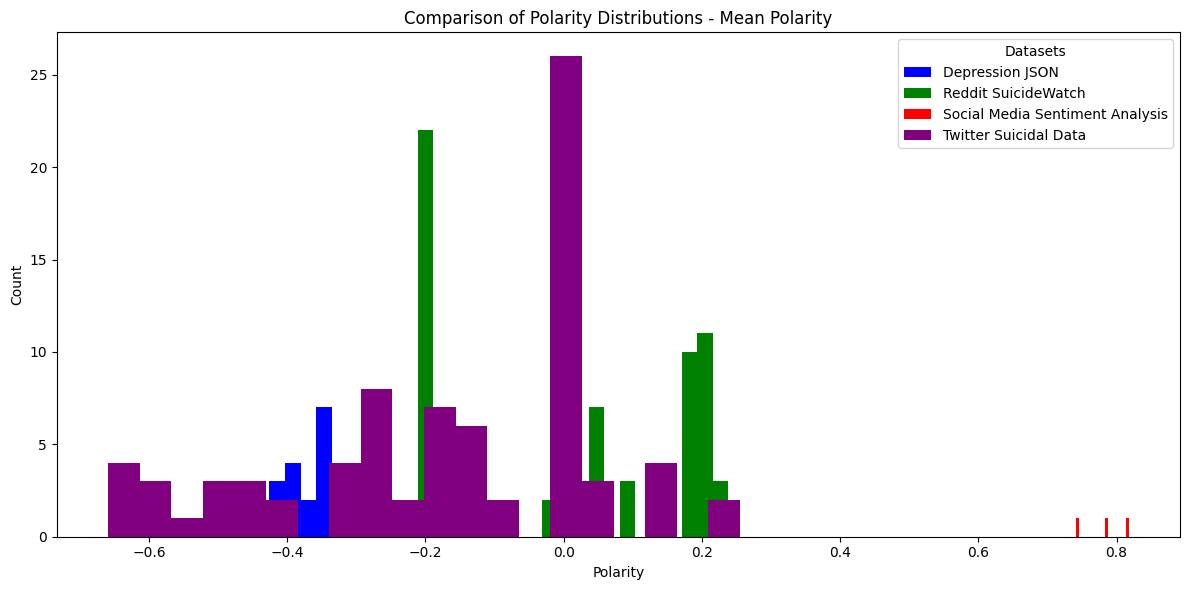

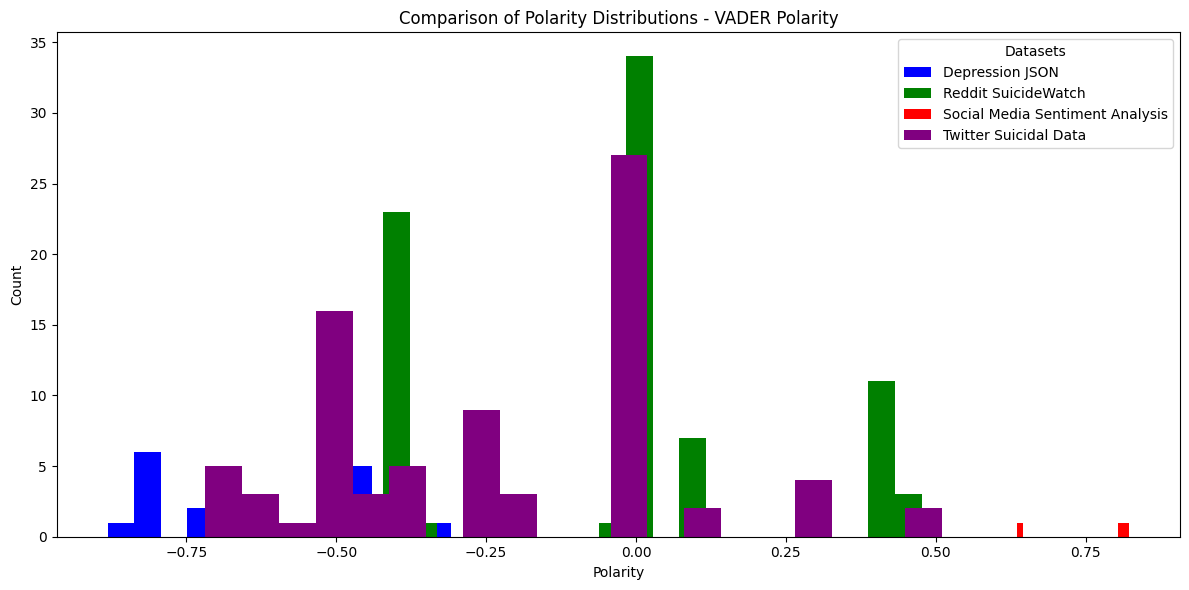

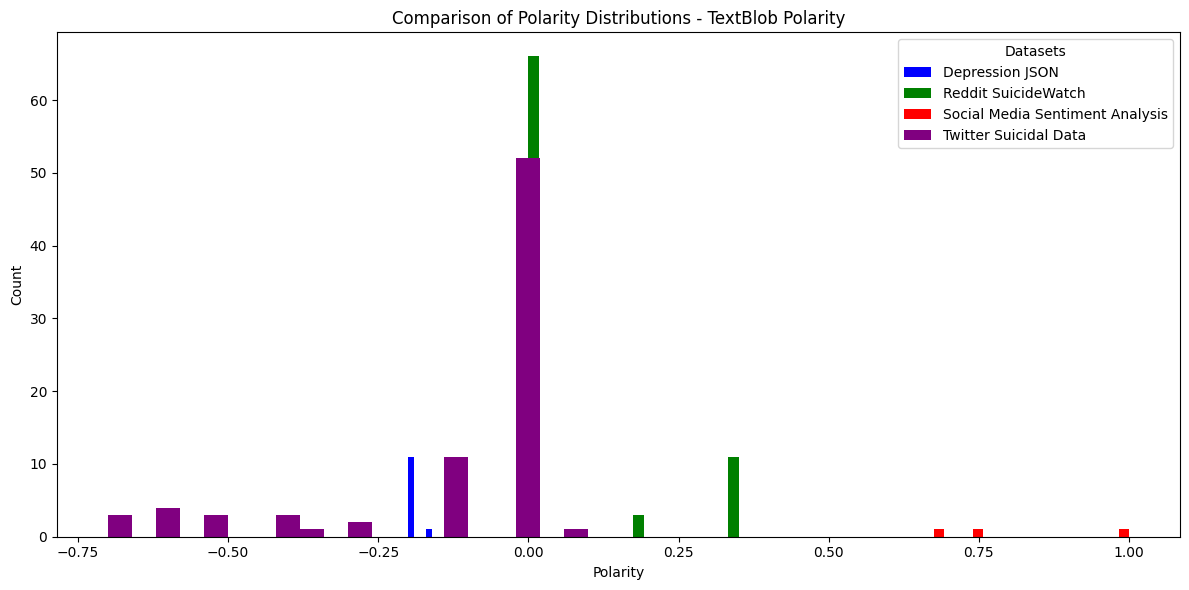

In [16]:
# Mean Polarity Distribution
plt.figure(figsize=(12, 6))
plt.title("Comparison of Polarity Distributions - Mean Polarity")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.hist(data=dataframes["depression_ngram"], x='mean_polarity', bins=20, color='blue', label='Depression JSON')
plt.hist(data=dataframes["reddit_ngram"], x='mean_polarity', bins=20, color='green', label='Reddit SuicideWatch')
plt.hist(data=dataframes["social_media_sentiment_analysis_ngram"], x='mean_polarity', bins=20, color='red', label='Social Media Sentiment Analysis')
plt.hist(data=dataframes["twitter_suicidal_ngram"], x='mean_polarity', bins=20, color='purple', label='Twitter Suicidal Data')
plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mean_polarity_distribution.png"))
plt.show()

# VADER Polarity Distribution
plt.figure(figsize=(12, 6))
plt.title("Comparison of Polarity Distributions - VADER Polarity")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.hist(data=dataframes["depression_ngram"], x='polarity_VADER', bins=20, color='blue', label='Depression JSON')
plt.hist(data=dataframes["reddit_ngram"], x='polarity_VADER', bins=20, color='green', label='Reddit SuicideWatch')
plt.hist(data=dataframes["social_media_sentiment_analysis_ngram"], x='polarity_VADER', bins=20, color='red', label='Social Media Sentiment Analysis')
plt.hist(data=dataframes["twitter_suicidal_ngram"], x='polarity_VADER', bins=20, color='purple', label='Twitter Suicidal Data')
plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "vader_polarity_distribution.png"))
plt.show()

# TextBlob Polarity Distribution
plt.figure(figsize=(12, 6))
plt.title("Comparison of Polarity Distributions - TextBlob Polarity")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.hist(data=dataframes["depression_ngram"], x='polarity_TextBlob', bins=20, color='blue', label='Depression JSON')
plt.hist(data=dataframes["reddit_ngram"], x='polarity_TextBlob', bins=20, color='green', label='Reddit SuicideWatch')
plt.hist(data=dataframes["social_media_sentiment_analysis_ngram"], x='polarity_TextBlob', bins=20, color='red', label='Social Media Sentiment Analysis')
plt.hist(data=dataframes["twitter_suicidal_ngram"], x='polarity_TextBlob', bins=20, color='purple', label='Twitter Suicidal Data')
plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "textblob_polarity_distribution.png"))
plt.show()

### N-gram Frequency VS Polarity Scatter Plot

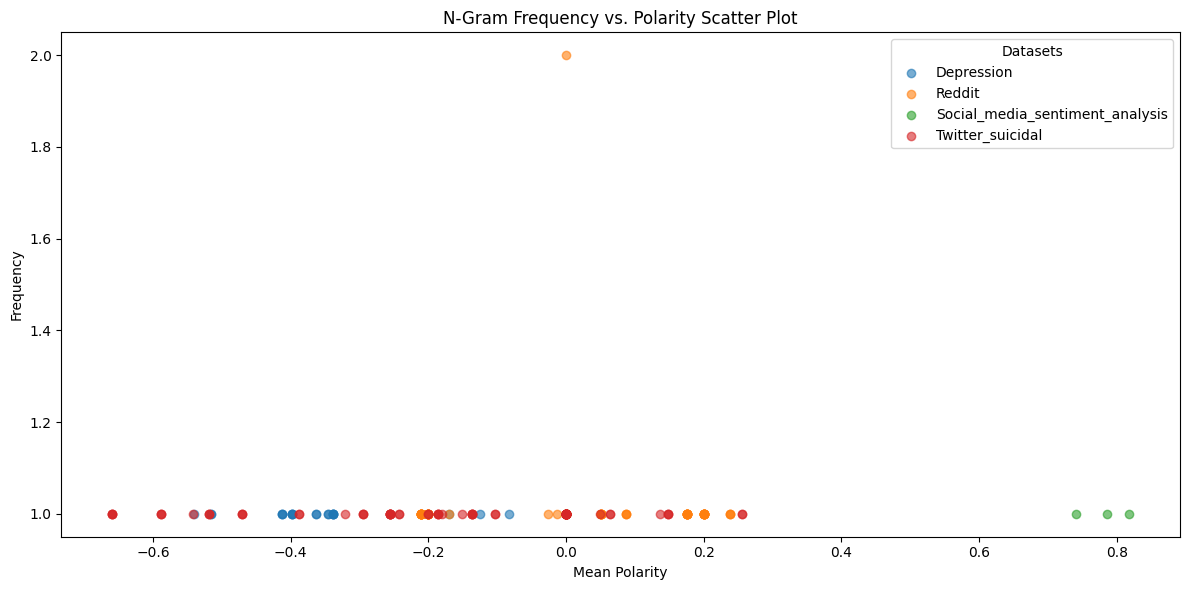

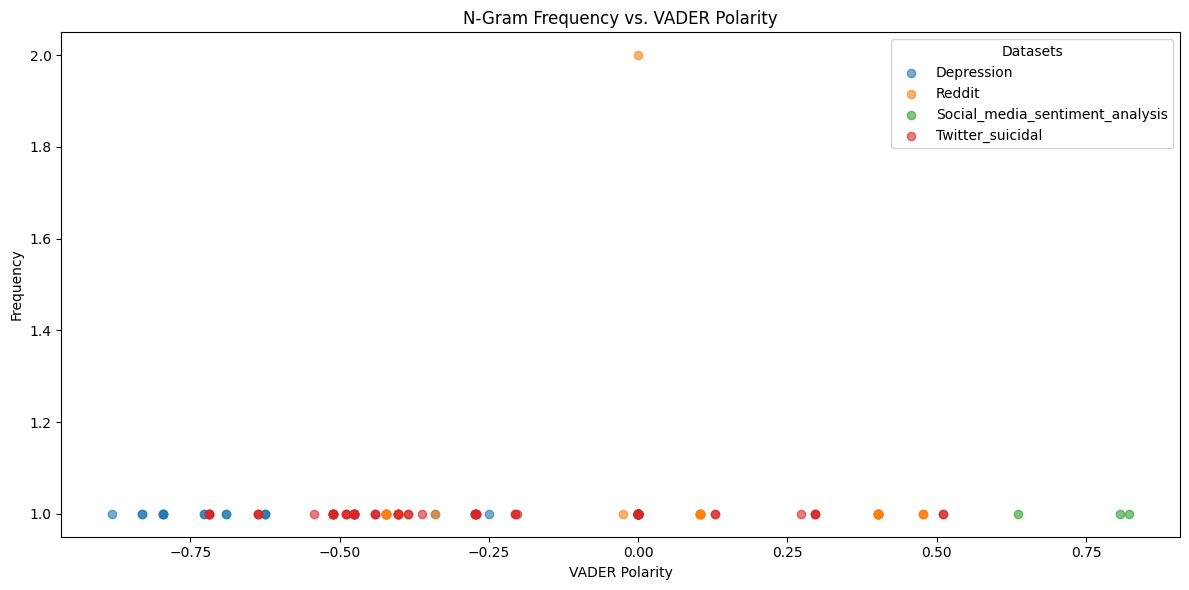

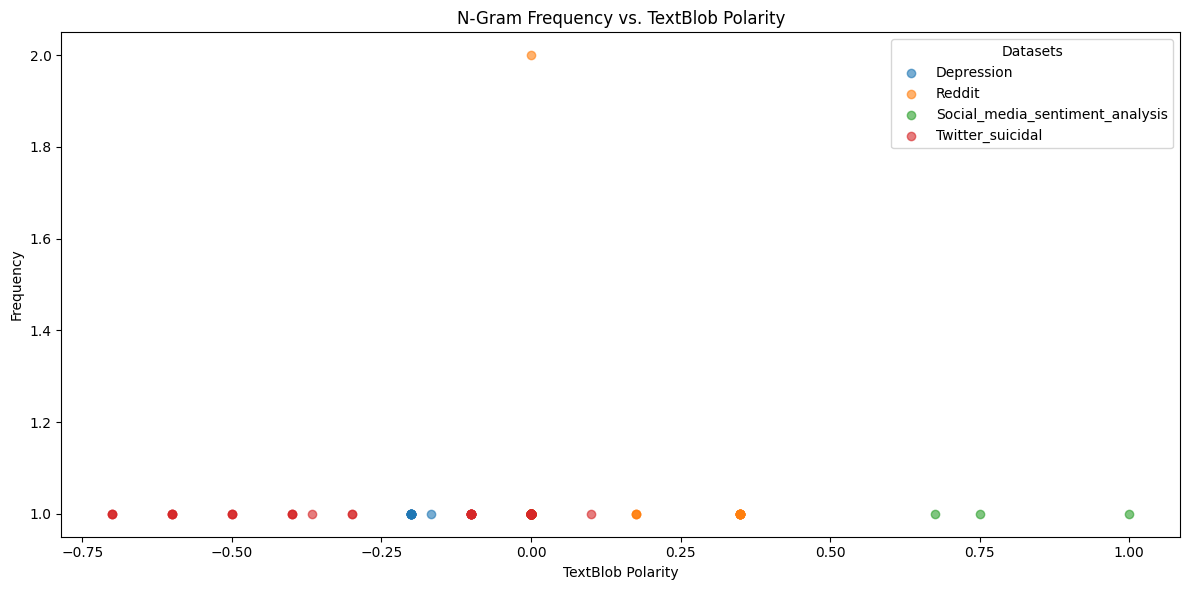

In [17]:
# Plot N-Gram Frequency VS Mean Polarity Scatter Plot
plt.figure(figsize=(12, 6))
plt.title("N-Gram Frequency vs. Polarity Scatter Plot")
plt.xlabel("Mean Polarity")
plt.ylabel("Frequency")

# Scatter plot for each dataset excluding prediction results
for dataset_name, df in dataframes.items():
    if "pred_results" not in dataset_name:
        plt.scatter(df['mean_polarity'], df['frequency'], label=dataset_name.split('_ngram')[0].capitalize(), alpha=0.6)

plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ngram_frequency_vs_polarity_scatter.png"))
plt.show()

# Plot N-Gram Frequency VS VADER Polarity
plt.figure(figsize=(12, 6))
plt.title("N-Gram Frequency vs. VADER Polarity")
plt.xlabel("VADER Polarity")
plt.ylabel("Frequency")

# Scatter plot for each dataset excluding prediction results
for dataset_name, df in dataframes.items():
    if "pred_results" not in dataset_name:
        plt.scatter(df['polarity_VADER'], df['frequency'], label=dataset_name.split('_ngram')[0].capitalize(), alpha=0.6)

plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ngram_frequency_vs_vader_polarity.png"))
plt.show()

# Plot N-Gram Frequency VS TextBlob Polarity
plt.figure(figsize=(12, 6))
plt.title("N-Gram Frequency vs. TextBlob Polarity")
plt.xlabel("TextBlob Polarity")
plt.ylabel("Frequency")

# Scatter plot for each dataset excluding prediction results
for dataset_name, df in dataframes.items():
    if "pred_results" not in dataset_name:
        plt.scatter(df['polarity_TextBlob'], df['frequency'], label=dataset_name.split('_ngram')[0].capitalize(), alpha=0.6)

plt.legend(title="Datasets")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "ngram_frequency_vs_textblob_polarity.png"))
plt.show()

### Average Emotion Distribution (VADER Scores)

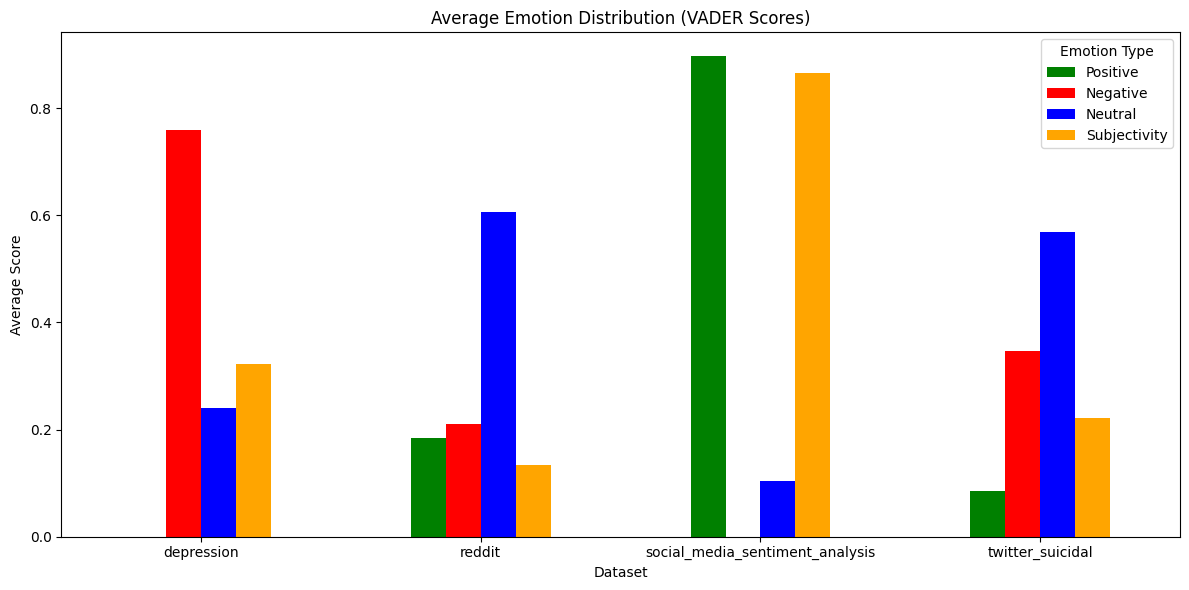

In [18]:
# Calculate average VADER scores for each dataset
average_emotions = {}
for dataset_name, df in dataframes.items():
    average_emotions[dataset_name] = {
        'Positive': df['positive'].mean(),
        'Negative': df['negative'].mean(),
        'Neutral': df['neutral'].mean(),
        'Subjectivity': df['subjectivity'].mean(),
    }

# Convert to a DataFrame for easier plotting
emotion_df = pd.DataFrame(average_emotions).T

# Rename the index to remove "_ngram" from the labels
emotion_df.index = emotion_df.index.str.replace('_ngram', '', regex=False)

# Filter out prediction results from the DataFrame
emotion_df = emotion_df[~emotion_df.index.str.contains('pred_results')]

# Plot the average emotion distribution
emotion_df.plot(kind='bar', figsize=(12, 6), color=['green', 'red', 'blue', 'orange'])
plt.title("Average Emotion Distribution (VADER Scores)")
plt.xlabel("Dataset")
plt.ylabel("Average Score")
plt.xticks(rotation=0)
plt.legend(title="Emotion Type")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "average_emotion_distribution.png"))
plt.show()

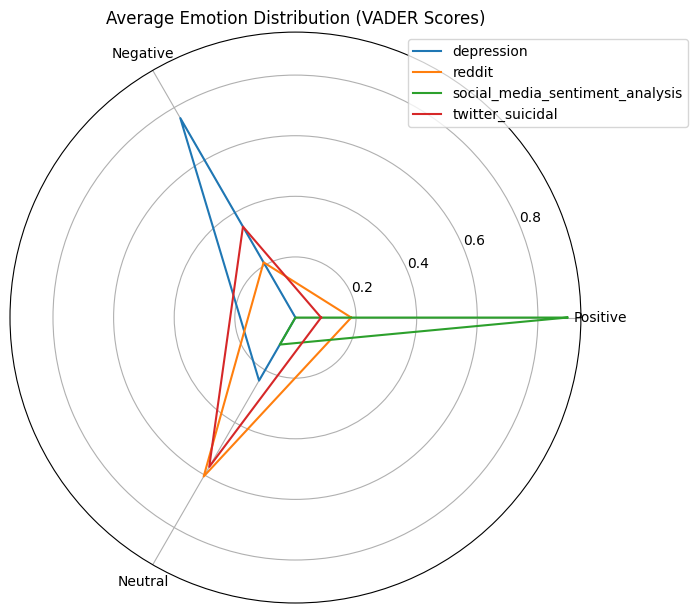

In [19]:
# Prepare data for radar chart
radar_data = emotion_df[['Positive', 'Negative', 'Neutral']]  # Select relevant columns
labels = radar_data.columns.tolist()
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

plt.figure(figsize=(7, 7))
for index, row in radar_data.iterrows():
    values = row.tolist()
    values += values[:1]  # Close the loop
    plt.polar(angles, values, label=index)

plt.xticks(angles[:-1], labels)
plt.title("Average Emotion Distribution (VADER Scores)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "average_emotion_distribution_radar.png"))
plt.show()

### Model Sensitivity To Negative Sentiment VS Predicted Label Rate

Predicted Label Rate = How likely a model predicts label = 1 (i.e., 'suicidal').

A Model's **Sensitivity** = how the number of negative sentiments or the likelihood of predicting a text to be suicidal affects predictions.

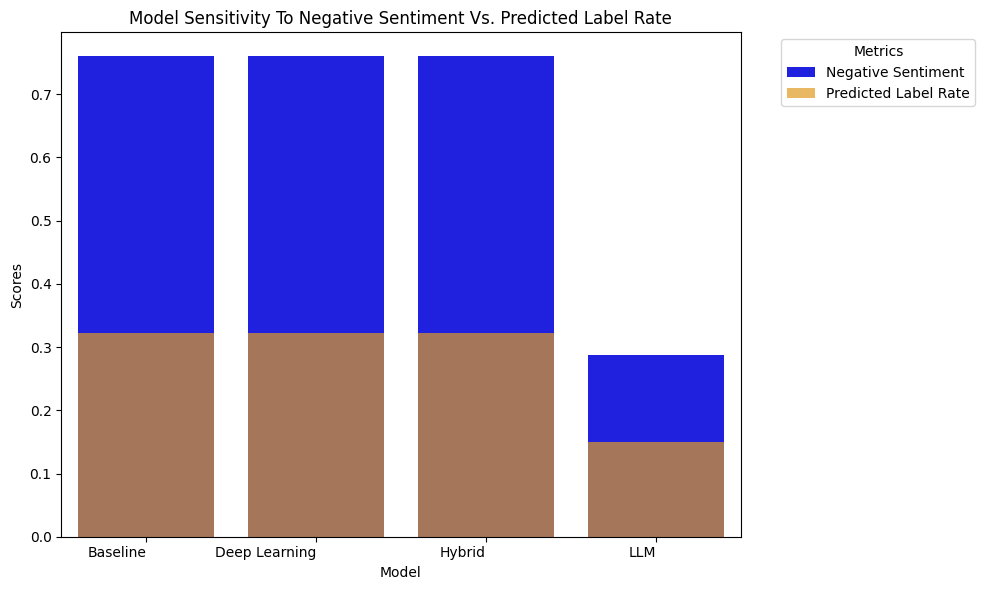

In [20]:
# Extract prediction results
prediction_results = {key: value for key, value in average_emotions.items() if "pred_results" in key}

# Calculate sensitivity to negative sentiment and predicted label rate
sensitivity_data = []
for model_name, metrics in prediction_results.items():
    negative_sentiment = metrics['Negative']
    predicted_label_rate = metrics['Subjectivity']  # Assuming subjectivity correlates with predicted label rate
    if "baseline" in model_name.lower():
        model_name = "Baseline"
    if "deep_learning" in model_name.lower():
        model_name = "Deep Learning"
    if "llm" in model_name.lower():
        model_name = "LLM"
    if "hybrid" in model_name.lower():
        model_name = "Hybrid"
    sensitivity_data.append((model_name, negative_sentiment, predicted_label_rate))

# Convert to DataFrame for plotting
sensitivity_df = pd.DataFrame(sensitivity_data, columns=['Model', 'Negative Sentiment', 'Predicted Label Rate'])

# Plot the data as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sensitivity_df, x='Model', y='Negative Sentiment', color='blue', label='Negative Sentiment')
sns.barplot(data=sensitivity_df, x='Model', y='Predicted Label Rate', color='orange', label='Predicted Label Rate', alpha=0.7)
plt.title("Model Sensitivity To Negative Sentiment Vs. Predicted Label Rate")
plt.xlabel("Model")
plt.ylabel("Scores")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_sensitivity_vs_predicted_label_rate_bar.png"))
plt.show()

C:\Users\kelvi\AppData\Local\Temp\ipykernel_10740\1432125897.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  curr_heatmap_data = df.groupby(['polarity_bin', 'predicted_label']).size().unstack(fill_value=0)
C:\Users\kelvi\AppData\Local\Temp\ipykernel_10740\1432125897.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  curr_heatmap_data = df.groupby(['polarity_bin', 'predicted_label']).size().unstack(fill_value=0)
C:\Users\kelvi\AppData\Local\Temp\ipykernel_10740\1432125897.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

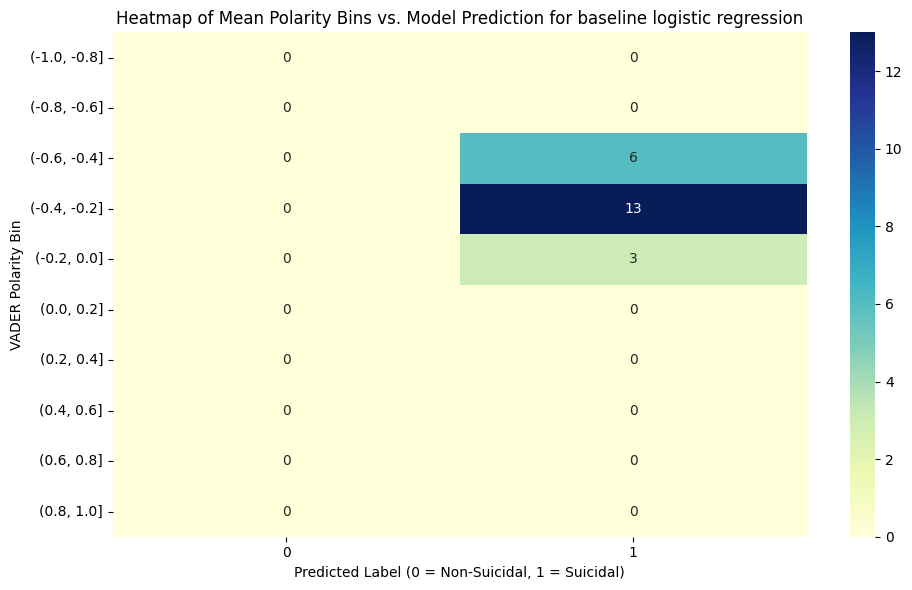

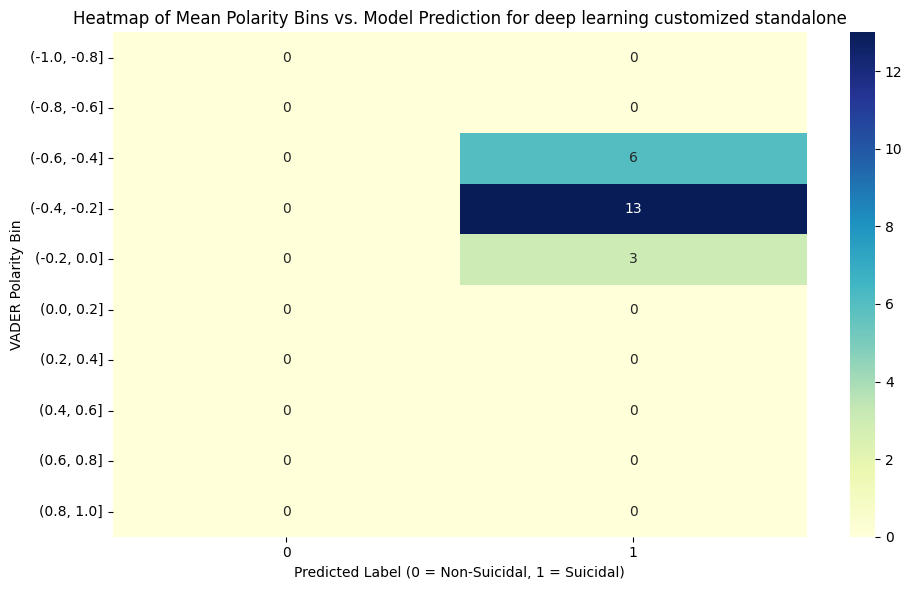

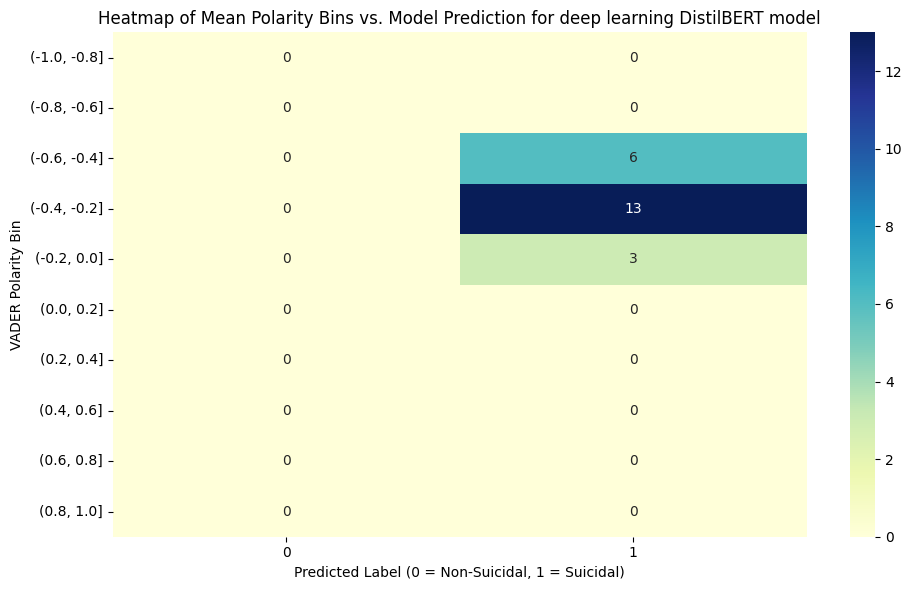

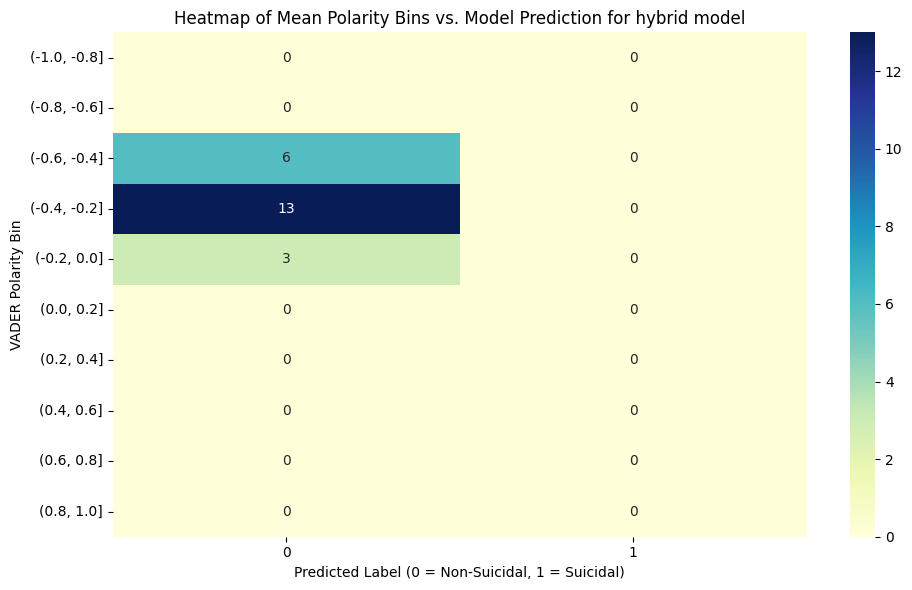

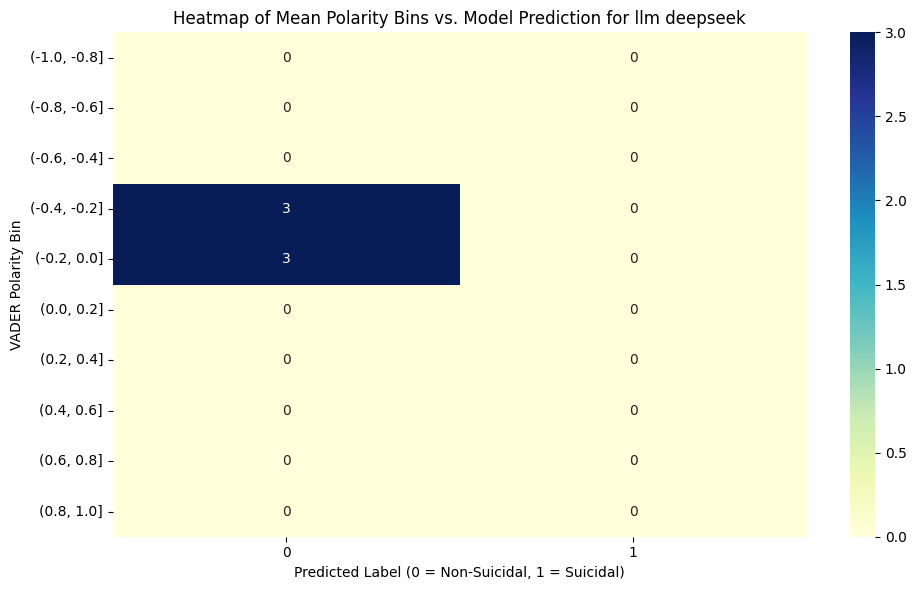

In [21]:
# Prepare data for heatmap with range-based bins
heatmap_data = {}
for dataset_name, df in dataframes.items():
    if "pred_results" in dataset_name:
        # Ensure the predicted label is in integer format
        df['predicted_label'] = df['predicted_label'].astype(int)
        # Bin mean polarity into range-based intervals
        df['polarity_bin'] = pd.cut(df['mean_polarity'], bins=np.linspace(-1, 1, 11))
        # Convert predicted label to categorical for heatmap
        df['predicted_label'] = pd.Categorical(df['predicted_label'], categories=[0, 1])
        # Heap Map Data
        curr_heatmap_data = df.groupby(['polarity_bin', 'predicted_label']).size().unstack(fill_value=0)
        heatmap_data[dataset_name] = curr_heatmap_data

# Plot heatmap for each dataset
for dataset_name, bin_counts in heatmap_data.items():
    formatted_name = " ".join(dataset_name.split('pred_results')[1][1:].split("_"))
    plt.figure(figsize=(10, 6))
    sns.heatmap(bin_counts, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Heatmap of Mean Polarity Bins vs. Model Prediction for {formatted_name}")
    plt.ylabel("VADER Polarity Bin")
    plt.xlabel("Predicted Label (0 = Non-Suicidal, 1 = Suicidal)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"heatmap_{dataset_name.split('.json')[0]}.png"))
    plt.show()

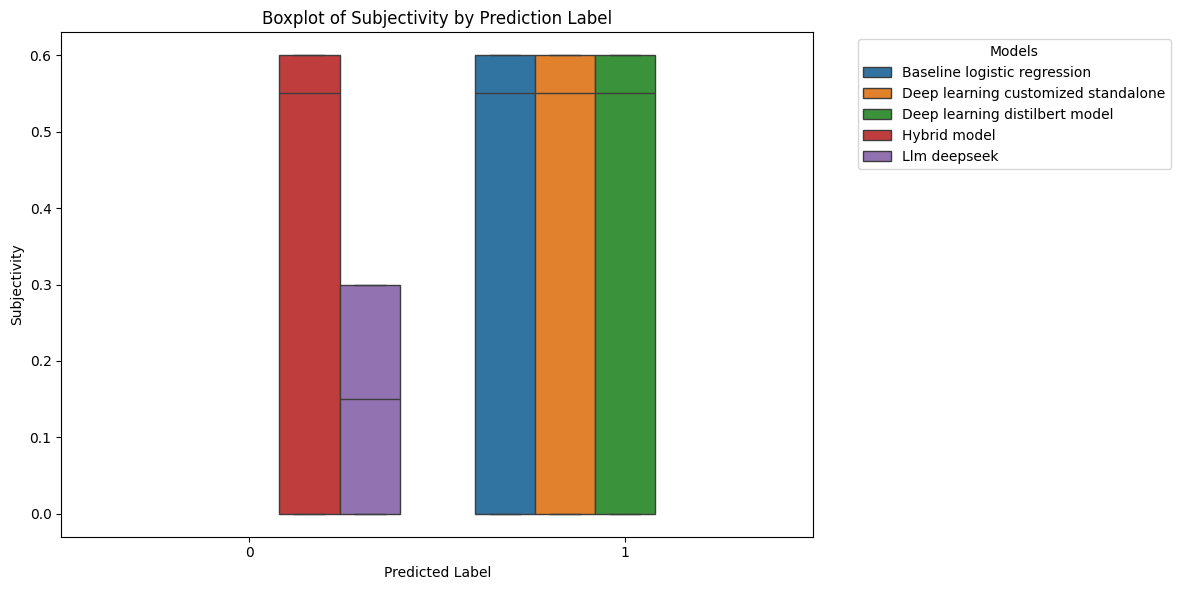

In [22]:
# Filter datasets with prediction results
prediction_datasets = {" ".join(key.split("pred_results")[1][1:].split("_")).capitalize(): value for key, value in dataframes.items() if "pred_results" in key}

# Combine all prediction datasets into a single DataFrame
combined_df = pd.concat(prediction_datasets.values(), keys=prediction_datasets.keys(), names=["Models", "Index"])

# Create a boxplot of subjectivity by predicted label
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x="predicted_label", y="subjectivity", hue="Models")
plt.title("Boxplot of Subjectivity by Prediction Label")
plt.xlabel("Predicted Label")
plt.ylabel("Subjectivity")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "boxplot_subjectivity_by_prediction_label.png"))
plt.show()